In [1]:
import pandas as pd 
import numpy as np 
import matplotlib as plt 
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA


In [2]:
#load the dataset 
df=pd.read_csv("TCS.csv",parse_dates=["Date"])

In [3]:
df

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2004-08-25,TCS,EQ,850.00,1198.70,1198.70,979.00,985.00,987.95,1008.32,17116372,1.725876e+15,NaN,5206360,0.3042
1,2004-08-26,TCS,EQ,987.95,992.00,997.00,975.30,976.85,979.00,985.65,5055400,4.982865e+14,NaN,1294899,0.2561
2,2004-08-27,TCS,EQ,979.00,982.40,982.40,958.55,961.20,962.65,969.94,3830750,3.715586e+14,NaN,976527,0.2549
3,2004-08-30,TCS,EQ,962.65,969.90,990.00,965.00,986.40,986.75,982.65,3058151,3.005106e+14,NaN,701664,0.2294
4,2004-08-31,TCS,EQ,986.75,986.50,990.00,976.00,987.80,988.10,982.18,2649332,2.602133e+14,NaN,695234,0.2624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4134,2021-04-26,TCS,EQ,3109.50,3102.05,3153.00,3088.05,3100.05,3100.80,3122.35,2490260,7.775465e+14,87012.0,1345353,0.5402
4135,2021-04-27,TCS,EQ,3100.80,3106.00,3136.10,3103.00,3132.75,3132.00,3122.18,1471417,4.594036e+14,97077.0,849767,0.5775
4136,2021-04-28,TCS,EQ,3132.00,3149.95,3151.00,3112.00,3123.00,3124.10,3125.72,1639037,5.123176e+14,76017.0,847762,0.5172
4137,2021-04-29,TCS,EQ,3124.10,3145.60,3157.35,3105.50,3114.45,3115.25,3130.83,1621395,5.076306e+14,98275.0,837567,0.5166


In [4]:
#keep what needed
df=df[["Date","Close","Volume"]].sort_values("Date")

In [5]:
ts = (df
      .set_index("Date")#mandadtory for all statsmodels
      .asfreq("B")      # 'B' = business day frequency
      .ffill())         # removes gaps that cause shape/zero-size errors

In [6]:
ts.tail

<bound method NDFrame.tail of               Close      Volume
Date                           
2004-08-25   987.95  17116372.0
2004-08-26   979.00   5055400.0
2004-08-27   962.65   3830750.0
2004-08-30   986.75   3058151.0
2004-08-31   988.10   2649332.0
...             ...         ...
2021-04-26  3100.80   2490260.0
2021-04-27  3132.00   1471417.0
2021-04-28  3124.10   1639037.0
2021-04-29  3115.25   1621395.0
2021-04-30  3035.65   3072305.0

[4353 rows x 2 columns]>

In [7]:
#train and test split 
# Hold out the last ~1 year (≈252 Indian trading days)
train = ts.iloc[:-252]
test  = ts.iloc[-252:]

y_train, y_test = train["Close"], test["Close"]
exog_train, exog_test = train["Volume"], test["Volume"]


In [8]:
from sklearn.metrics import mean_absolute_error

def plot_forecast(actual, pred, title):
    plt.figure(figsize=(8,4))
    plt.plot(actual.index, actual,  label="Actual")
    plt.plot(pred.index,   pred,    label="Forecast")
    plt.title(title); plt.legend(); plt.show()


ARIMA MAE: 711.7317048963704


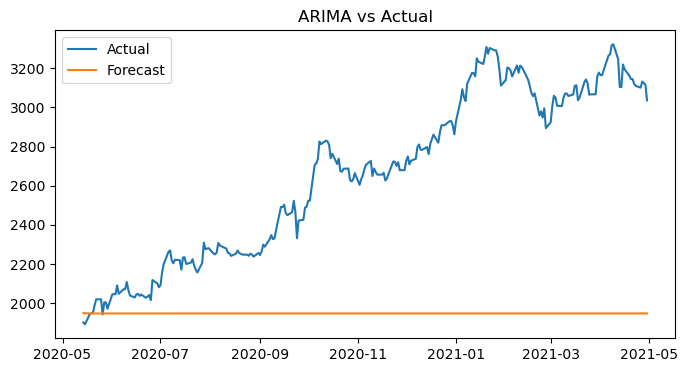

In [9]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Fit ARIMA model
arima_model = ARIMA(y_train, order=(5,1,0))
arima_result = arima_model.fit()

# Forecast
arima_pred = arima_result.forecast(steps=len(test)).rename("ARIMA")

# Print error
print("ARIMA MAE:", mean_absolute_error(y_test, arima_pred))

# Plot
def plot_forecast(actual, pred, title):
    plt.figure(figsize=(8,4))
    plt.plot(actual.index, actual, label="Actual")
    plt.plot(pred.index, pred, label="Forecast")
    plt.title(title)
    plt.legend()
    plt.show()

plot_forecast(y_test, arima_pred, "ARIMA vs Actual")


In [10]:
arimax = ARIMA(endog=y_train, exog=exog_train, order=(5,1,0)).fit()
arimax_pred = arimax.forecast(len(test), exog=exog_test).rename("ARIMAX")
print("ARIMAX MAE:", mean_absolute_error(y_test, arimax_pred))


C:\Users\VANSHIKA\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMAX MAE: 713.0405191928405


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima = SARIMAX(y_train,
                 order=(2,1,2),
                 seasonal_order=(1,0,1,252),  # season = 1 trading year
                 enforce_stationarity=False,
                 enforce_invertibility=False).fit()
sarima_pred = sarima.forecast(len(test)).rename("SARIMA")
print("SARIMA MAE:", mean_absolute_error(y_test, sarima_pred))


In [ ]:
sarimax = SARIMAX(y_train,
                  exog=exog_train,
                  order=(2,1,2),
                  seasonal_order=(1,0,1,252),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()
sarimax_pred = sarimax.forecast(len(test), exog=exog_test).rename("SARIMAX")
print("SARIMAX MAE:", mean_absolute_error(y_test, sarimax_pred))
plot_forecast(y_test, sarimax_pred, "SARIMAX vs Actual")


In [ ]:
from prophet import Prophet

# Prophet expects 'ds' and 'y'
prophet_train = y_train.reset_index().rename(columns={"Date":"ds","Close":"y"})

m = Prophet(daily_seasonality=False, yearly_seasonality=True)
m.fit(prophet_train)

future = m.make_future_dataframe(periods=len(test), freq="B")
forecast = m.predict(future)

prophet_pred = forecast.set_index("ds")["yhat"].iloc[-len(test):].rename("Prophet")
print("Prophet MAE:", mean_absolute_error(y_test, prophet_pred))
plot_forecast(y_test, prophet_pred, "Prophet vs Actual")
